## Con colores.

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

# ----------------------------
# Parámetros de imagen
# ----------------------------
img_height = 224
img_width  = 224
batch_size = 32

# ----------------------------
# Rutas de los datasets
# ----------------------------
train_dir = "data/train"
test_dir  = "data/test"

# ----------------------------
# Funciones de preprocesado
# ----------------------------
def apply_heatmap_safe(img_tensor):
    img = img_tensor.numpy()
    img = (img * 255).astype('uint8')
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    heatmap = cv2.applyColorMap(img_gray, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (img_width, img_height))
    heatmap = heatmap.astype('float32') / 255.0
    return heatmap

def preprocess_with_heatmap(img, label):
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0

    def heat():
        return tf.py_function(apply_heatmap_safe, [img], Tout=tf.float32)

    # 40% de imágenes en heatmap
    img_final = tf.cond(tf.random.uniform([]) < 0.4, heat, lambda: img)
    img_final.set_shape([img_height, img_width, 3])
    return img_final, label

# ----------------------------
# Cargar dataset de entrenamiento
# ----------------------------
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    batch_size=None
)

# Crear validación a partir del train (80% train, 20% val)
train_size = int(0.8 * len(full_train_ds))
train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

# Aplicar preprocesado con heatmaps
train_ds = train_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)

# Preparar batches y prefetch
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# Dataset de test
# ----------------------------
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size=None
)

test_ds = test_ds.map(preprocess_with_heatmap, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset listo con 40% de imágenes en heatmap")

Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
✅ Dataset listo con 40% de imágenes en heatmap


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import cv2


# ----------------------------
# Calcular pesos de clase para balancear
# ----------------------------
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# ----------------------------
# Crear modelo CNN (como tu versión original)
# ----------------------------
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ----------------------------
# Entrenamiento
# ----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=22,
    class_weight=class_weights
)

# ----------------------------
# Evaluación en test
# ----------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")

# ----------------------------
# Gráficas de Accuracy y Loss
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Evolución de la pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ----------------------------
# Matriz de confusión y reporte
# ----------------------------
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

# ----------------------------
# Mostrar 5 imágenes aleatorias con predicción
# ----------------------------
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
   
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow(images[idx].numpy())
        plt.axis("off")
        color_warning = "red" if preds_classes[idx] == 1 else "green"
        plt.title(f"{class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color_warning)
plt.show()

# ----------------------------
# Guardar modelo
# ----------------------------
model.save("modelo_cnn.h5")
print("✅ Modelo guardado como modelo_cnn.h5")

Class weights: {0: np.float64(0.9427579365079365), 1: np.float64(1.0646426170737173)}
Epoch 1/22


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1/297 ━━━━━━━━━━━━━━━━━━━━ 12:38 3s/step - accuracy: 0.6875 - loss: 0.6698

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


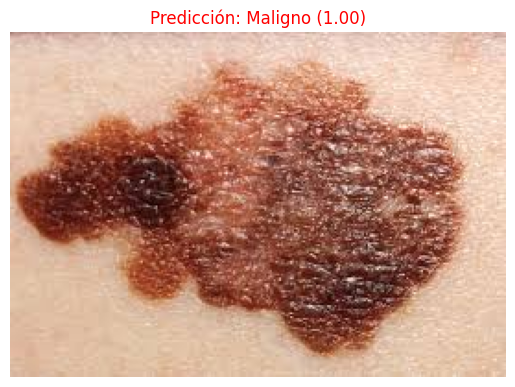

👉 Resultado: Maligno con probabilidad 1.00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Función para analizar imagen
# ============================
def analizar_imagen(ruta_imagen, model, img_height=224, img_width=224, threshold=0.4):
    # Cargar la imagen
    img = tf.keras.utils.load_img(ruta_imagen, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)

    # Normalizar a [0,1]
    img_array = img_array / 255.0

    # Añadir dimensión batch
    img_array = np.expand_dims(img_array, axis=0)

    # Predicción
    pred = model.predict(img_array)[0][0]

    # Clasificación
    clase = "Maligno" if pred > threshold else "Benigno"

    # Mostrar resultado
    plt.imshow(tf.keras.utils.load_img(ruta_imagen))
    plt.axis("off")
    plt.title(f"Predicción: {clase} ({pred:.2f})", color="red" if clase=="Maligno" else "green")
    plt.show()

    return clase, pred

# ============================
# Uso de la función
# ============================
ruta = "C:/Users/aserr/Downloads/FotoMelanoma1.jpeg"  # <-- pon aquí la ruta de tu imagen
clase, prob = analizar_imagen(ruta, model)
print(f"👉 Resultado: {clase} con probabilidad {prob:.2f}")


Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9440691436518974), 1: np.float64(1.0629753914988815)}


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,977,633 (99.10 MB)

 Trainable params: 25,977,633 (99.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 215s 719ms/step - accuracy: 0.6990 - loss: 0.5562 - val_accuracy: 0.7938 - val_loss: 0.4287
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 213s 718ms/step - accuracy: 0.7818 - loss: 0.4491 - val_accuracy: 0.8114 - val_loss: 0.3955
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 217s 729ms/step - accuracy: 0.8021 - loss: 0.4212 - val_accuracy: 0.8300 - val_loss: 0.3874
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 216s 726ms/step - accuracy: 0.8103 - loss: 0.3995 - val_accuracy: 0.8098 - val_loss: 0.3817
Epoch 5/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 206s 695ms/step - accuracy: 0.8176 - loss: 0.3906 - val_accuracy: 0.8472 - val_loss: 0.3571
Epoch 6/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 261s 691ms/step - accuracy: 0.8266 - loss: 0.3749 - val_accuracy: 0.8510 - val_loss: 0.3564
Epoch 7/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 214s 721ms/step - accuracy: 0.8389 - loss: 0.3585 - val_accuracy: 0.8628 - val_loss: 0.3151
Epoch 8/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 224s 753ms/step - accuracy: 0.8459 -

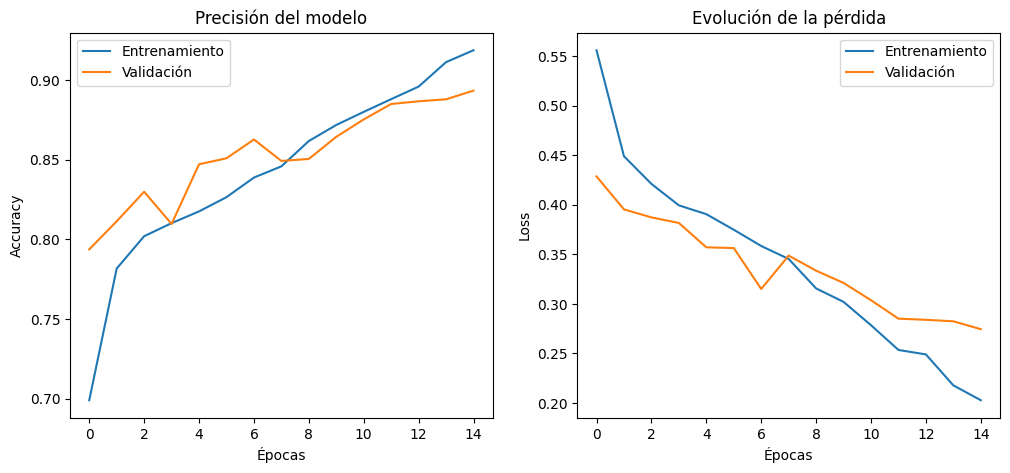

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step


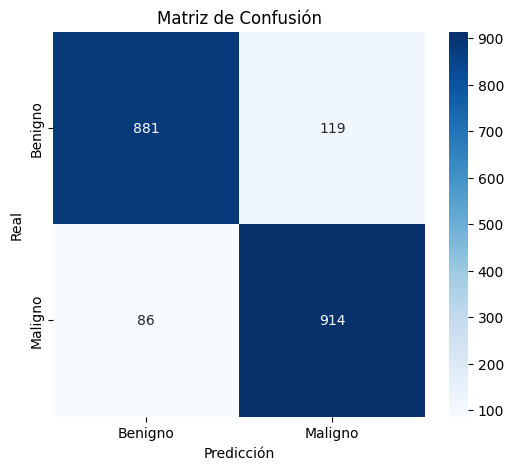


📊 Reporte de Clasificación:
              precision    recall  f1-score   support

     Benigno       0.91      0.88      0.90      1000
     Maligno       0.88      0.91      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


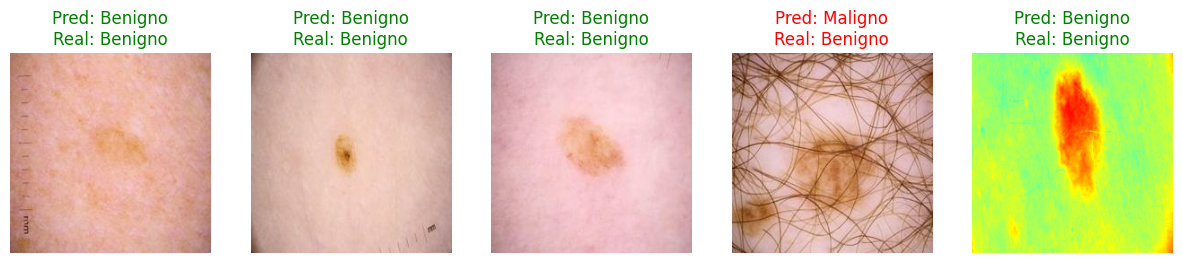

✅ Modelo guardado como modelo_cnn.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1️⃣ Obtener nombres de clases (a partir de test_ds o train_dir)
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2️⃣ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3️⃣ Crear el modelo CNN
# ===========================================================
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # 👈 Clasificación binaria
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

# ===========================================================
# 4️⃣ Entrenamiento
# ===========================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights
)

# ===========================================================
# 5️⃣ Evaluación en test
# ===========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")

# ===========================================================
# 6️⃣ Gráficas de Accuracy y Loss
# ===========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Evolución de la pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===========================================================
# 7️⃣ Matriz de confusión y reporte de clasificación
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("\n📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 8️⃣ Mostrar 5 imágenes aleatorias con su predicción
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))  # ✅ corregido
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()


# ===========================================================
# 9️⃣ Guardar modelo
# ===========================================================
model.save("modelo_cnn.h5")
print("✅ Modelo guardado como modelo_cnn.h5")


## MODELO 2
He cambiado: 
- primera capa de 32 a 64 filtros 
- Aumentamos el Dropout a 0.65
- Cambio el optimizador de Adam a RMSprop
- HE bajado learning rate de 0.001 que es el predeterminado a 0.0005 

Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9457603503184714), 1: np.float64(1.0608394730966733)}


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,024,641 (99.28 MB)

 Trainable params: 26,024,641 (99.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 286s 961ms/step - accuracy: 0.6778 - loss: 0.5896 - val_accuracy: 0.7765 - val_loss: 0.4813
Epoch 2/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 285s 961ms/step - accuracy: 0.7871 - loss: 0.4632 - val_accuracy: 0.8098 - val_loss: 0.4012
Epoch 3/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 283s 952ms/step - accuracy: 0.8022 - loss: 0.4317 - val_accuracy: 0.8056 - val_loss: 0.3912
Epoch 4/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 275s 925ms/step - accuracy: 0.8068 - loss: 0.4160 - val_accuracy: 0.8110 - val_loss: 0.3899
Epoch 5/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 272s 917ms/step - accuracy: 0.8232 - loss: 0.3941 - val_accuracy: 0.8215 - val_loss: 0.3762
Epoch 6/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 275s 925ms/step - accuracy: 0.8356 - loss: 0.3686 - val_accuracy: 0.7900 - val_loss: 0.4269
Epoch 7/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 273s 920ms/step - accuracy: 0.8408 - loss: 0.3619 - val_accuracy: 0.8451 - val_loss: 0.3483
Epoch 8/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 273s 919ms/step - accuracy: 0.8427 -

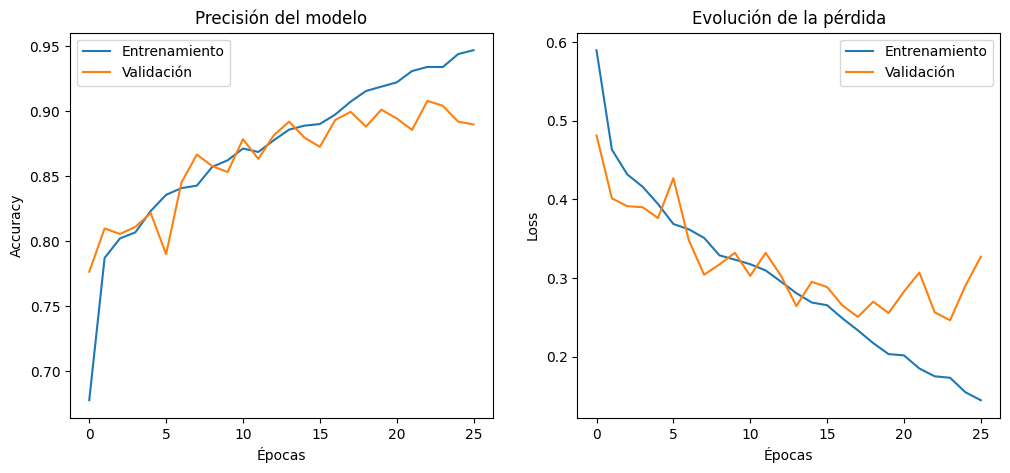

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step


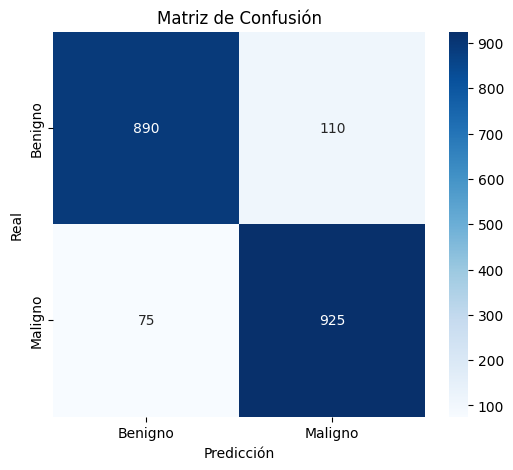


📊 Reporte de Clasificación:
              precision    recall  f1-score   support

     Benigno       0.92      0.89      0.91      1000
     Maligno       0.89      0.93      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


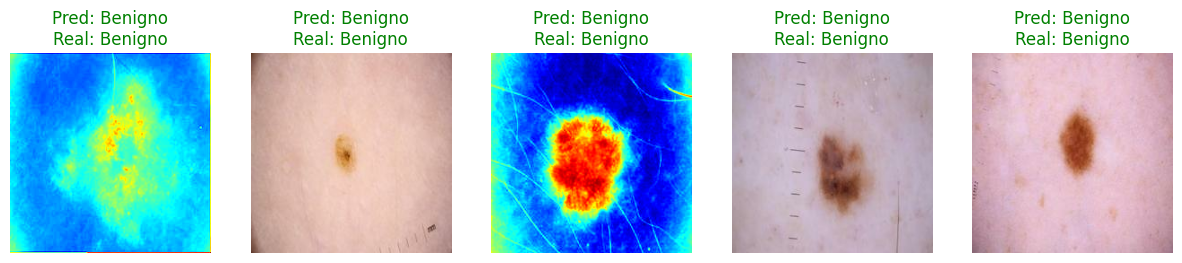

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1️⃣ Obtener nombres de clases (a partir de test_ds o train_dir)
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2️⃣ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3️⃣ Crear el modelo CNN
# ===========================================================
model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.65),
    layers.Dense(1, activation='sigmoid')  # 👈 Clasificación binaria
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.0005,  
        rho=0.9,
        momentum=0.0
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ===========================================================
# 4️⃣ Entrenamiento
# ===========================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=26,
    class_weight=class_weights
)

# ===========================================================
# 5️⃣ Evaluación en test
# ===========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")

# ===========================================================
# 6️⃣ Gráficas de Accuracy y Loss
# ===========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Evolución de la pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===========================================================
# 7️⃣ Matriz de confusión y reporte de clasificación
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("\n📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 8️⃣ Mostrar 5 imágenes aleatorias con su predicción
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))  # ✅ corregido
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()

# ===========================================================
# 9️⃣ Guardar modelo
model.save("modelo2_cnn.h5")


## Modelo 3 

He cambiado: 
- Numero de filtros, al doble comparado con el Modelo 1
- He subido el learning rate comparado con el modelo 2, ahora es como el modelo 1
- Dropout de 0.6

Clases detectadas: ['Benigno', 'Maligno']
Pesos de clase: {0: np.float64(0.9440691436518974), 1: np.float64(1.0629753914988815)}


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,906,881 (396.37 MB)

 Trainable params: 103,906,881 (396.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.5928 - loss: 0.7021 - val_accuracy: 0.6961 - val_loss: 0.5384
Epoch 2/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 636s 2s/step - accuracy: 0.7313 - loss: 0.5272 - val_accuracy: 0.8043 - val_loss: 0.4143
Epoch 3/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 635s 2s/step - accuracy: 0.7822 - loss: 0.4599 - val_accuracy: 0.7399 - val_loss: 0.4840
Epoch 4/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 635s 2s/step - accuracy: 0.7967 - loss: 0.4409 - val_accuracy: 0.7988 - val_loss: 0.4176
Epoch 5/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 635s 2s/step - accuracy: 0.8039 - loss: 0.4266 - val_accuracy: 0.8249 - val_loss: 0.4068
Epoch 6/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 636s 2s/step - accuracy: 0.8080 - loss: 0.4117 - val_accuracy: 0.8182 - val_loss: 0.4432
Epoch 7/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 634s 2s/step - accuracy: 0.8166 - loss: 0.4026 - val_accuracy: 0.8085 - val_loss: 0.3857
Epoch 8/26
297/297 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - accuracy: 0.8318 - loss: 0.3715 - val_accu

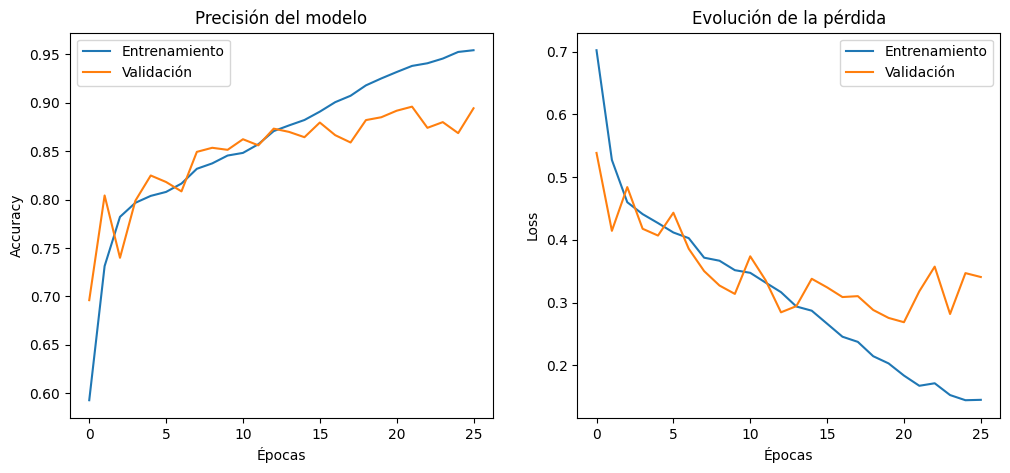

63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 505ms/step


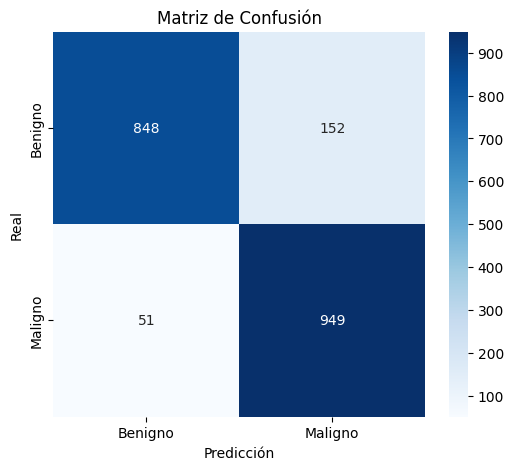


📊 Reporte de Clasificación:
              precision    recall  f1-score   support

     Benigno       0.94      0.85      0.89      1000
     Maligno       0.86      0.95      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


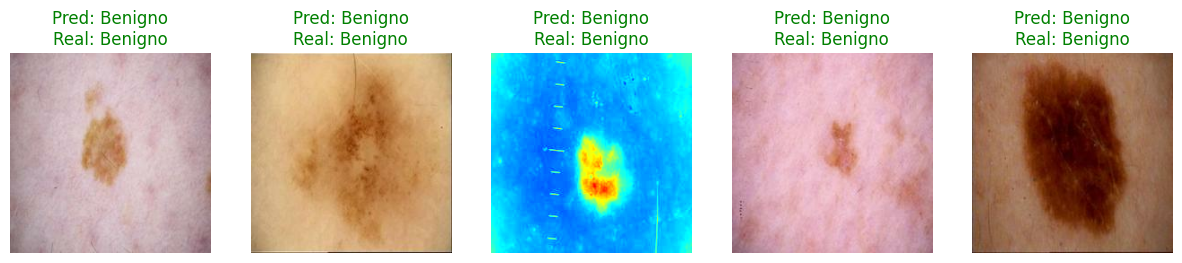

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1️⃣ Obtener nombres de clases (a partir de test_ds o train_dir)
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2️⃣ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3️⃣ Crear el modelo CNN
# ===========================================================
model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(1, activation='sigmoid')  # 👈 Clasificación binaria
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.001,  
        rho=0.9,
        momentum=0.0
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ===========================================================
# 4️⃣ Entrenamiento
# ===========================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=26,
    class_weight=class_weights
)

# ===========================================================
# 5️⃣ Evaluación en test
# ===========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")

# ===========================================================
# 6️⃣ Gráficas de Accuracy y Loss
# ===========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Evolución de la pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===========================================================
# 7️⃣ Matriz de confusión y reporte de clasificación
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("\n📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 8️⃣ Mostrar 5 imágenes aleatorias con su predicción
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))  # ✅ corregido
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()

# ===========================================================
# 9️⃣ Guardar modelo
model.save("modelo3_cnn.h5")


## Modelo 4 
- Bajado los filtros a los mismos que el primer modelo
- Learning rate menor, 0.0005
- Dropout de 0.725
- Hasta 17 epochs

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# ===========================================================
# 1️⃣ Obtener nombres de clases (a partir de test_ds o train_dir)
# ===========================================================
class_names = test_ds.class_names if hasattr(test_ds, "class_names") else [
    "Benigno", "Maligno"
]
print("Clases detectadas:", class_names)

# ===========================================================
# 2️⃣ Calcular pesos de clase para balancear dataset
# ===========================================================
y_train_list = []
for _, y in train_ds.unbatch():
    y_train_list.append(y.numpy())
y_train = np.array(y_train_list)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

# ===========================================================
# 3️⃣ Crear el modelo CNN
# ===========================================================
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.725),
    layers.Dense(1, activation='sigmoid')  # 👈 Clasificación binaria
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=0.0005,  
        rho=0.9,
        momentum=0.0
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ===========================================================
# 4️⃣ Entrenamiento
# ===========================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    class_weight=class_weights
)

# ===========================================================
# 5️⃣ Evaluación en test
# ===========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")

# ===========================================================
# 6️⃣ Gráficas de Accuracy y Loss
# ===========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Evolución de la pérdida")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ===========================================================
# 7️⃣ Matriz de confusión y reporte de clasificación
# ===========================================================
y_true_list = []
for _, y in test_ds.unbatch():
    y_true_list.append(y.numpy())
y_true = np.array(y_true_list)

y_pred_prob = model.predict(test_ds)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("\n📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# 8️⃣ Mostrar 5 imágenes aleatorias con su predicción
# ===========================================================
plt.figure(figsize=(15,6))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = (preds > threshold).astype("int32").flatten()
    indices = random.sample(range(len(images)), 5)
    for i, idx in enumerate(indices):
        plt.subplot(1,5,i+1)
        plt.imshow((images[idx].numpy() * 255).astype("uint8"))  # ✅ corregido
        plt.axis("off")
        color = "green" if preds_classes[idx] == int(labels[idx]) else "red"
        plt.title(f"Pred: {class_names[preds_classes[idx]]}\nReal: {class_names[int(labels[idx])]}", color=color)
plt.show()

# ===========================================================
# 9️⃣ Guardar modelo
model.save("modelo4_cnn.h5")


ModuleNotFoundError: No module named 'matplotlib'